In [9]:
from rpy2 import robjects
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import matplotlib.dates as mdates
import multiprocessing as mp
import pandas as pd
import numpy as np
import datetime
import yaml
import os
# Convert pandas dataframe
from rpy2.robjects import pandas2ri
pandas2ri.activate()

output_dir = 'output_14-21-newdata/'

dept_avail = os.listdir(output_dir)

rainfall = pd.read_csv('haiti-data/fromAzman/rainfall.csv', index_col = 0, parse_dates = True)
cases    = pd.read_csv('haiti-data/fromAzman/cases_corrected.csv', index_col=0, parse_dates =True)

compartments = ['S', 'I', 'A', 'RA1', 'RA2', 'RA3', 'RI1', 'RI2', 'RI3', 'W', 'B', 'cases', 'C',
                 "VSd", "VRI1d", "VRI2d", "VRI3d", "VRA1d", "VRA2d", "VRA3d",
                 "VSdd", "VRI1dd", "VRI2dd", "VRI3dd", "VRA1dd", "VRA2dd", "VRA3dd",
                 "VSd_alt", "VRI1d_alt", "VRI2d_alt", "VRI3d_alt", "VRA1d_alt", "VRA2d_alt", "VRA3d_alt",
                 "VSdd_alt", "VRI1dd_alt", "VRI2dd_alt", "VRI3dd_alt", "VRA1dd_alt", "VRA2dd_alt", "VRA3dd_alt"]

stream = open('haiti-data/input_parameters.yaml', 'r')
input_parameters = yaml.load(stream)

dept_name = [list(pop.keys())[0] for pop in input_parameters['population']]

t_start = input_parameters['t_start']
t_for = datetime.date(2029,12,20)

# computes precipitation sample
def project_rain(rainfall, tf):
    nd = 14 #days sampled - must be multiple of 7 d
    
    dti = rainfall.iloc[0].name.date()
    dtf = rainfall.iloc[-1].name.date()
    
    rain_prj_index = pd.DatetimeIndex(start =  dtf + datetime.timedelta(1), 
                                      end = tf, freq = 'D')
    rain_prj = np.zeros((rain_prj_index.shape[0], 10))

    # Full years of data available
    years = range(dti.year+1, dtf.year-1)

    # each nd days, assign an al precipitation.
    for i, date in enumerate(pd.date_range(dtf + datetime.timedelta(1), tf, freq = str(nd)+'D')):
        dd = date.day
        if (date.month == 2 and dd == 29):
            dd = 28
        pick = datetime.date(np.random.choice(years), date.month, dd)
        #print(pick, i, rainfall.loc[pd.date_range(pick, pick + datetime.timedelta(nd-1))].values.shape, rain_prj[nd * i: nd * (i+1)].shape)
        rain_prj[nd * i: nd * (i+1)] = rainfall.loc[pd.date_range(pick, pick + datetime.timedelta(nd-1))].values

    rain_prj = pd.DataFrame(rain_prj, index = rain_prj_index, columns = dept_name)
    
    return rain_prj

rain_prj = project_rain(rainfall, t_for)
rain = pd.concat((rainfall, rain_prj))
rain.to_csv('haiti-data/proj/rainfall.csv', index_label = 'date')

In [ ]:
nsim = 1000
run_lvl = 3
n_proc = 8

In [16]:
index = pd.DatetimeIndex(start =  t_start,  end = t_for, freq = 'W-SAT')

covar_init = pd.concat([cases[t_start:]]*6, ignore_index=True)[0:-506]
covar_init.index = pd.DatetimeIndex(start =  datetime.date(2010,10,23), 
                                      end = t_for, freq = 'W-SAT')
covar_init.to_csv('covar_mob.csv', index_label='date')

all_data = {}

def run_sim(dp):
    # see second answer of https://stackoverflow.com/questions/25175530/can-rpy2-code-be-run-in-parallel on why it starts different 
    # R instances
    r_source = robjects.r['source'];
    dept_data = {}
    robjects.r('departement <- "' + dp + '"')
    robjects.r('output_dir <- "' + output_dir + '"')
    robjects.r('run_level <- ' + str(run_lvl))
    robjects.r('nsim <- ' + str(nsim))
    robjects.r('t_vacc_start <- "' + str('2010-01-01') + '"')
    robjects.r('t_vacc_end  <- "' + str('2010-01-01') + '"')
    robjects.r('p1d_reg <- 0') 
    robjects.r('r_v_year <- 0')
    robjects.r('cases_ext <- 1')
    r_source('~/phd/haiti-ocv-pomp/scripts/forecast_haitiOCV_mob.R')

    if i == 0:
        all_params = pd.DataFrame(np.zeros((len(dept_avail), len(robjects.r('names(params)')))),  columns = robjects.r('names(params)'), index = dept_avail)        
    #all_params.loc[dp] = robjects.r['params']
    for comp in compartments:
        temp = pandas2ri.ri2py(robjects.r[comp])
        temp.index = index
        temp.drop('date',axis=1, inplace = True)
        dept_data[comp] = temp
    return (dp, dept_data, robjects.r['params'])
    #all_data[dp] = dept_data
    
    
with mp.Pool(processes=n_proc) as pool:
    for dp, dept_data, params in pool.imap_unordered(run_sim, dept_avail):
        all_data[dp] = dept_data
        all_params.loc[dp] = params


# Convert years in days, 'mu', 'alpha'
rates = [ "gammaI", "gammaA", "rhoA", 'rhoI', 'mu_B']
params_disp = all_params.copy()
params_disp.loc[:,'rhoI'] = params_disp.loc[:,'XrhoI'] * params_disp.loc[:,'rhoA']
params_disp.loc[:,'thetaA'] = params_disp.loc[:,'XthetaA'] * params_disp.loc[:,'thetaI']
params_disp.drop(['mu', 'alpha', 'XrhoI', 'XthetaA', 't_vacc_start', 't_vacc_end', 'p1d_reg', 'r_v_year', 'H', 'D', 'Rtot_0'], axis =1, inplace = True)
print(params_disp)
for p in rates:
    params_disp.loc[:,p] =  1/(params_disp.loc[:,p]/365.25)
    
params_disp = params_disp.reindex(columns=sorted(params_disp.columns))

/usr/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Parsed with column specification:
cols(
  .default = col_double(),
  XrhoI = col_integer(),
  cases_ext = col_integer(),
  t_vacc_start = col_integer(),
  t_vacc_end = col_integer(),
  p1d_reg = col_integer(),
  r_v_year = col_integer()
)

  warnings.warn(x, RRuntimeWarning)
/usr/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: See spec(...) for full column specifications.

  warnings.warn(x, RRuntimeWarning)
/usr/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Parsed with column specification:
cols(
  .default = col_double(),
  XrhoI = col_integer(),
  cases_ext = col_integer(),
  t_vacc_start = col_integer(),
  t_vacc_end = col_integer(),
  p1d_reg = col_integer(),
  r_v_year = col_integer()
)

  warnings.warn(x, RRuntimeWarning)
/usr/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: See spec(...) for full column spe

                sigma     betaB        mu_B    thetaI    lambdaR         r  \
Artibonite   0.949817  0.128705  250.237116  0.000628   0.513733  0.724918   
Grande_Anse  0.686002  0.596252  108.847383  0.000610  13.769998  1.651420   

              gammaI   gammaA      rhoA       foi_add   epsilon           k  \
Artibonite   182.625  182.625  0.125086  4.657182e-07  0.693990  185.993303   
Grande_Anse  182.625  182.625  0.125086  4.823893e-07  0.242668   47.105877   

                std_W  cases_ext      rhoI    thetaA  
Artibonite   0.007117        1.0  0.125086  0.000011  
Grande_Anse  0.048261        1.0  0.125086  0.000185  


### Extracting best performing parameters

In [19]:
params_disp

,betaB,cases_ext,epsilon,foi_add,gammaA,gammaI,k,lambdaR,mu_B,r,rhoA,rhoI,sigma,std_W,thetaA,thetaI
Artibonite,0.128705,1.0,0.693990,4.657182e-07,2.0,2.0,185.993303,0.513733,1.459616,0.724918,2920.0,2920.0,0.949817,0.007117,0.000011,0.000628
Grande_Anse,0.596252,1.0,0.242668,4.823893e-07,2.0,2.0,47.105877,13.769998,3.355616,1.651420,2920.0,2920.0,0.686002,0.048261,0.000185,0.000610


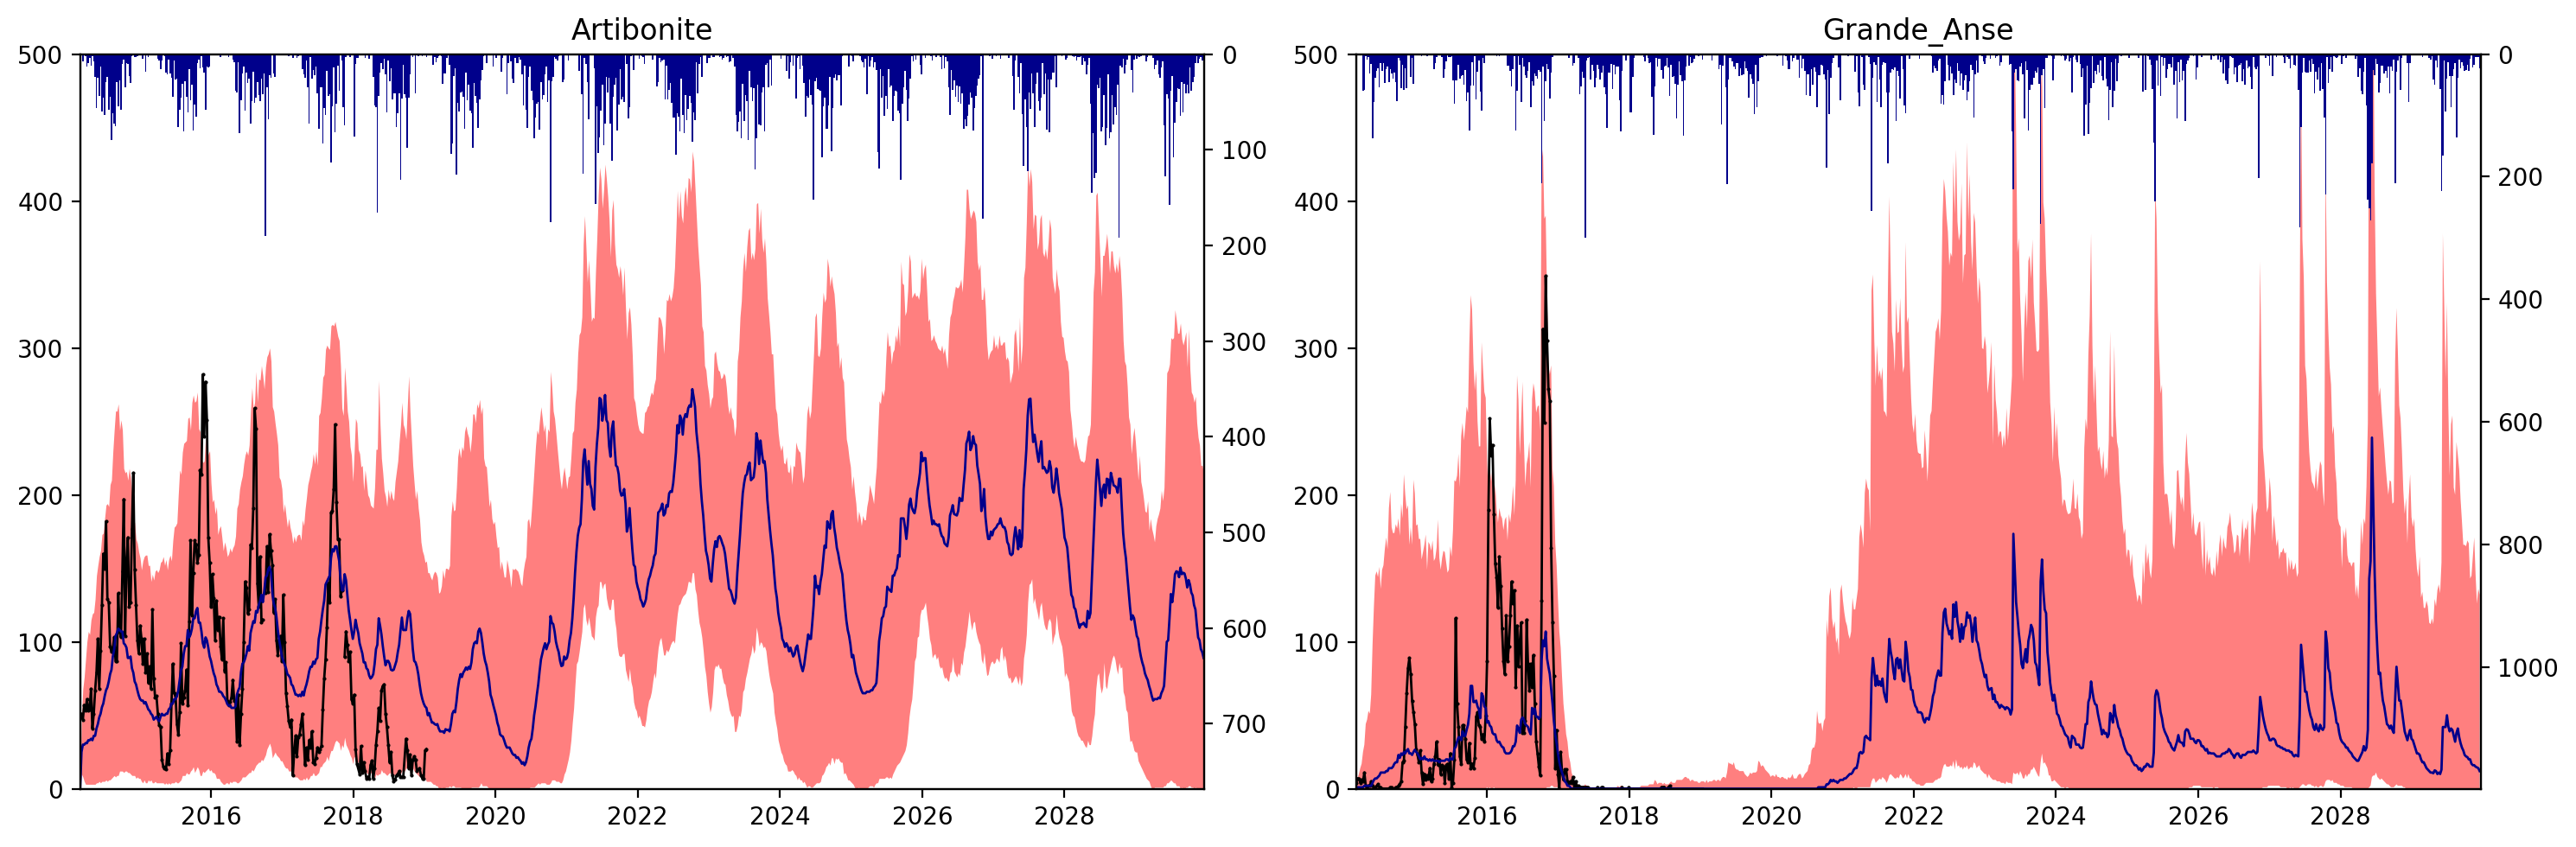

In [18]:
ti = input_parameters['t_start']
tf = input_parameters['t_end']
tf = t_for
#tf = datetime.date(2018,7,21)

fig, axes = plt.subplots((len(all_data))//2, 2, figsize=(15,5), squeeze = True, dpi = 200);
fig.patch.set_facecolor('white')
axes = axes.flatten();
for i, dp in enumerate(dept_avail):
#for i, dp in enumerate(['Artibonite', 'Nord-Est', 'Ouest']):

    axt =  axes[i].twinx()
    axes[i].plot(cases[dp][t_start:][ti:tf], marker='.', linestyle='-',color='k', linewidth=1, markersize=1 ) 
    axes[i].fill_between(all_data[dp]['cases']['q05'][ti:tf].index, all_data[dp]['cases']['q05'][ti:tf], all_data[dp]['cases']['q95'][ti:tf], alpha = .5, color = 'red', linewidth = 0)
    axes[i].plot(all_data[dp]['cases']['q50'][ti:tf], alpha = 1,linestyle='-', linewidth = 1, color = 'darkblue')
    axt.bar(pd.date_range(ti,tf, freq='W-SAT').date, rain[dp].resample('W-SAT').sum()[ti:tf], label = r'Rainfall', color = 'darkblue', width=7, alpha = 1)

    axes[i].set_title(dp)
    axes[i].set_ylim(0, 500)
    axt.set_ylim(4*max(rain[dp].resample('W-SAT').sum()[t_start:t_for]),0) # check if only reverse y
    axes[i].set_xlim(ti, tf)
    #axes[i].legend()
    
fig.tight_layout()

In [ ]:
import seaborn as sns
sns.pairplot(params_disp, markers = '.')

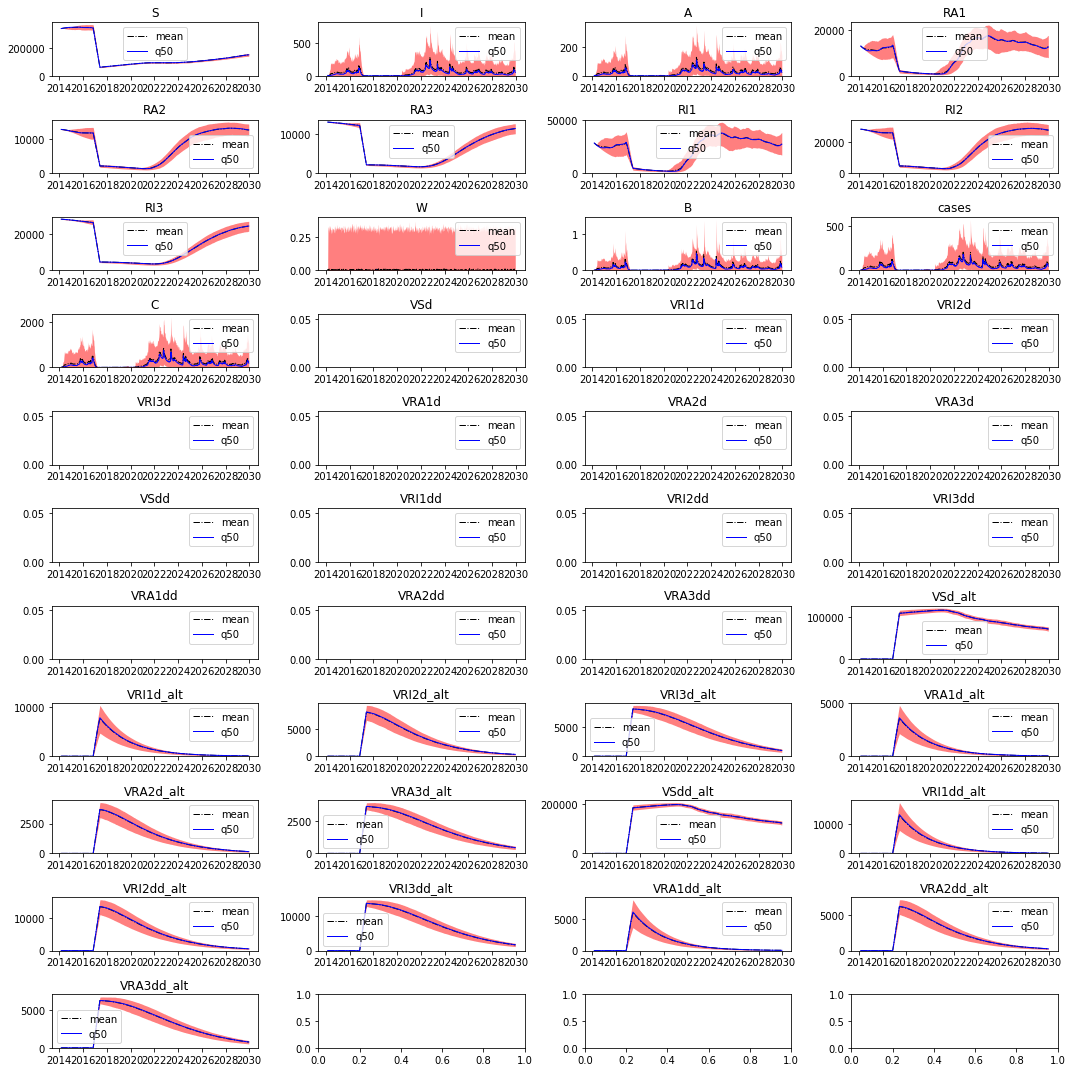

In [8]:
dp = 'Grande_Anse'
fig, axes = plt.subplots((len(compartments))//4+1, 4, figsize=(15,15), squeeze = True);
axes = axes.flatten();
for i, comp in enumerate(compartments):
    axes[i].fill_between(all_data[dp][comp]['q05'].index, all_data[dp][comp]['q05'], all_data[dp][comp]['q95'], alpha = .5, color = 'red', linewidth = 0)
    axes[i].plot(all_data[dp][comp]['mean'], linewidth=1, alpha = 1,linestyle='-.', color = 'black')
    axes[i].plot(all_data[dp][comp]['q50'], alpha = 1,linestyle='-', linewidth = 1, color = 'blue') 
    axes[i].set_title(comp)
    axes[i].legend()
    axes[i].set_ylim(0)
    
fig.tight_layout()

In [64]:
class VaccinationScenario():

    def __init__(self, course_year, percent_completely_unvaccinated, percent_onedose, percent_twodoses, not_dep = []):
        pop = {'Artibonite':1727524,
        'Centre':746236,
        'Grande_Anse':468301,
        'Nippes':342525,
        'Nord':1067177,
        'Nord-Est':393967,
        'Nord-Ouest':728807,
        'Ouest':4029705,
        'Sud':774976,
        'Sud-Est':632601}

        ocv_order = ['Centre', 'Artibonite','Ouest','Nord-Ouest','Nord','Sud', 'Nippes','Nord-Est', 'Sud-Est','Grande_Anse']


        self.t_vacc_start = {}
        self.t_vacc_end = {}
        self.p1d_reg = {}
        self.r_v_year = {}

        #20% completely unvaccinated, 10% one-dose only, 70% two doses

        t_init = datetime.date(2018,7,14)
        days_per_departement = int((course_year*365)/len(ocv_order))

        for i, dp in enumerate(ocv_order):
            if dp not in not_dep:
                self.t_vacc_start[dp] = t_init + datetime.timedelta(days=i*days_per_departement)
                self.t_vacc_end[dp] = t_init + datetime.timedelta(days=(i+1)*days_per_departement)
                self.p1d_reg[dp] = percent_onedose/(percent_onedose + percent_twodoses)
                self.r_v_year[dp] = pop[dp]*(100-percent_completely_unvaccinated)/100/days_per_departement * 365.25

            else:
                self.t_vacc_start[dp] = t_init + datetime.timedelta(days=i*days_per_departement)
                self.t_vacc_end[dp] = t_init + datetime.timedelta(days=(i+1)*days_per_departement)
                self.p1d_reg[dp] = 0
                self.r_v_year[dp] =0



S1 = VaccinationScenario(2, 20, 10, 70)
S2 = VaccinationScenario(2, 20, 10, 70, not_dep=['Ouest','Nord-Ouest','Sud', 'Nippes','Nord-Est', 'Sud-Est','Grande_Anse'])
S3 = VaccinationScenario(5, 20, 10, 70)
#S2 = VaccinationScenario(2, 40, 20, 40, not_dep=['Ouest','Nord-Ouest','Sud', 'Nippes','Nord-Est', 'Sud-Est','Grande_Anse'])
S4 = VaccinationScenario(2, 3.33, 1.67, 95)
S5 = VaccinationScenario(2, 3.33, 1.67, 95, not_dep=['Ouest','Nord-Ouest','Sud', 'Nippes','Nord-Est', 'Sud-Est','Grande_Anse'])
S6 = VaccinationScenario(5, 3.33, 1.67, 95)
scenario = S6
scenario_str = 'S6'


### Vaccination without mobility

In [65]:
# Running simulation:
index = pd.DatetimeIndex(start =  t_start,  end = t_for, freq = 'W-SAT')
r_source = robjects.r['source'];

covar_init = pd.concat([cases[t_start:]]*6, ignore_index=True)[0:-362]
covar_init.index = pd.DatetimeIndex(start =  datetime.date(2010,10,23), 
                                      end = t_for, freq = 'W-SAT')
covar_init.to_csv('covar_mob.csv', index_label='date')

all_data_vacc = {}
for i, dp in enumerate(dept_avail):
    dept_data = {}
    robjects.r('departement <- "' + dp + '"')
    robjects.r('output_dir <- "' + output_dir + '"')
    robjects.r('run_level <- ' + str(run_lvl))
    robjects.r('nsim <- ' + str(nsim))
    
    robjects.r('t_vacc_start <- "' + str(scenario.t_vacc_start[dp]) + '"')
    robjects.r('t_vacc_end  <- "' + str(scenario.t_vacc_end[dp]) + '"')
    robjects.r('p1d_reg <- ' + str(scenario.p1d_reg[dp]))
    robjects.r('r_v_year <- ' + str(scenario.r_v_year[dp]))
    robjects.r('cases_ext <- 1')
    if dp == 'Artibonite':
        robjects.r('calib_corr <- ' + str((cases[t_start:].mean().sum() - cases[t_start:][dp].mean())/10))
    elif (dp == 'Nord-Est'):
        robjects.r('calib_corr <- ' + str((cases[t_start:].mean().sum() - cases[t_start:][dp].mean())*8))
    elif ((dp == 'Sud-Est') or (dp == 'Nippes')):
        robjects.r('calib_corr <- ' + str((cases[t_start:].mean().sum() - cases[t_start:][dp].mean())*5))
    elif dp == 'Ouest':
        robjects.r('calib_corr <- ' + str((cases[t_start:].mean().sum() - cases[t_start:][dp].mean())/15))
    else:
        robjects.r('calib_corr <- ' + str(cases[t_start:].mean().sum() - cases[t_start:][dp].mean()))

    print(dp)

    r_source('~/phd/haiti-ocv-pomp/scripts/forecast_haitiOCV_mob.R')
  
    for comp in compartments:
        temp = pandas2ri.ri2py(robjects.r[comp])
        temp.index = index
        temp.drop('date',axis=1, inplace = True)
        dept_data[comp] = temp
    all_data_vacc[dp] = dept_data

Artibonite
Ouest


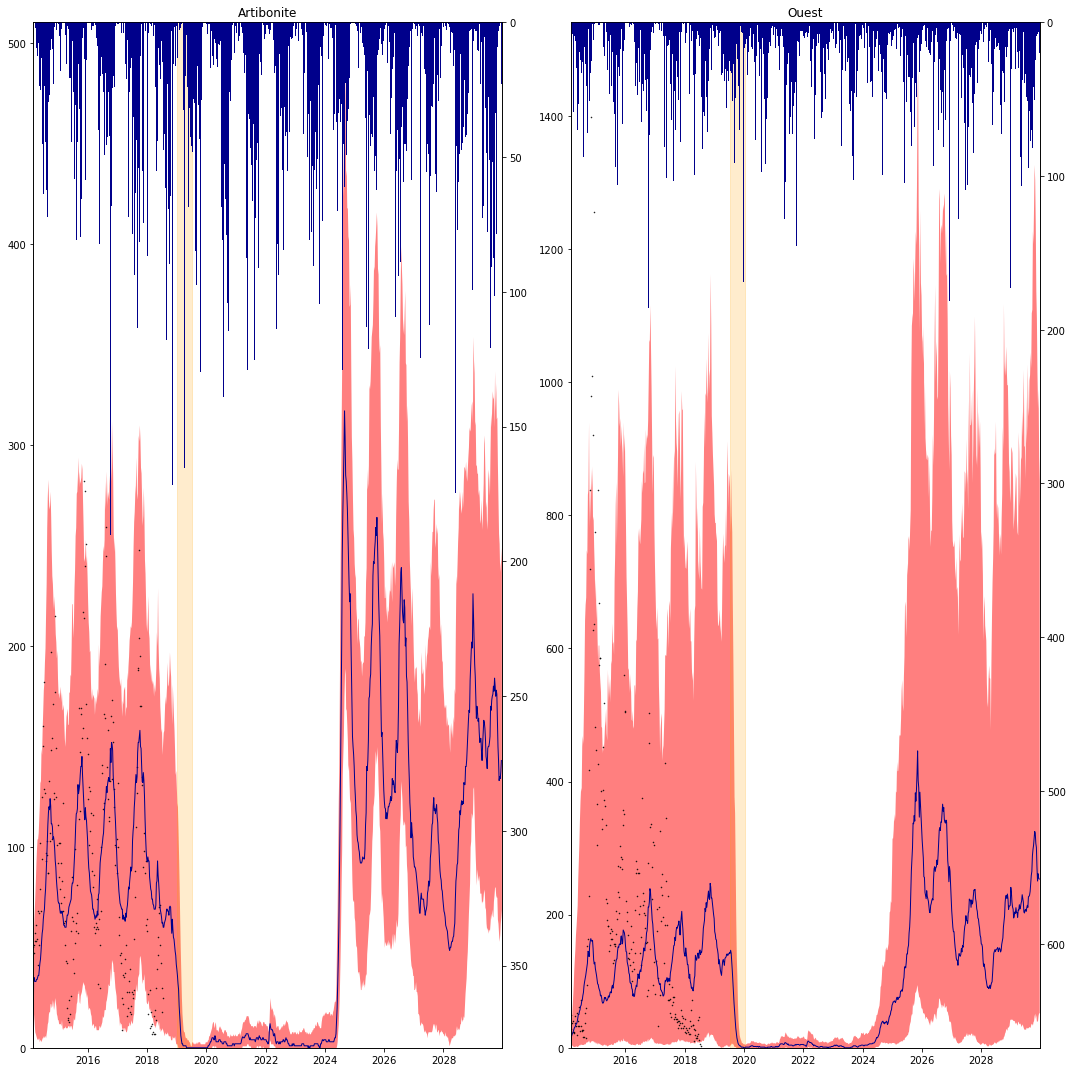

In [66]:
fig, axes = plt.subplots((len(all_data))//2, 2, figsize=(15,15), squeeze = True);
axes = axes.flatten();
fig.patch.set_facecolor('white')

for i, dp in enumerate(dept_avail):
    axt =  axes[i].twinx()
    axes[i].plot(cases[dp][t_start:], marker='.', linestyle='-',color='k', linewidth=0, markersize=1 ) 
    axes[i].fill_between(all_data_vacc[dp]['cases']['q05'].index, all_data_vacc[dp]['cases']['q05'], all_data_vacc[dp]['cases']['q95'], alpha = .5, color = 'red', linewidth = 0)
    axes[i].plot(all_data_vacc[dp]['cases']['q50'], alpha = 1,linestyle='-', linewidth = 1, color = 'darkblue')
    axt.bar(pd.date_range(t_start,t_for, freq='W-SAT').date, rain[dp].resample('W-SAT').sum()[t_start:t_for], 
                label = r'Rainfall', color = 'darkblue', width=7, alpha = 1)

    axes[i].set_title(dp)
    axes[i].set_ylim(0)
    axt.set_ylim(2*max(rain[dp].resample('W-SAT').sum()[t_start:t_for]),0) # check if only reverse y
    axes[i].set_xlim(t_start, t_for)
    #axes[i].legend()
    

    # convert to matplotlib date representation
    start = mdates.date2num(scenario.t_vacc_start[dp])
    end = mdates.date2num(scenario.t_vacc_end[dp])
    width = end - start
    rect = Rectangle((start, 0), width, 100+max(all_data_vacc[dp]['cases']['q95']), color='orange', alpha= 0.1)
    axes[i].add_patch(rect) 
    axes[i].add_artist(rect)
    rx, ry = rect.get_xy()
    cx = rx + rect.get_width()/2.0
    cy = ry + rect.get_height()/1.5
    #axes[i].annotate(r'Vaccination', (cx, cy), color='black',# weight='bold', 
    #            fontsize=12, ha='center', va='center', rotation='vertical')

fig.tight_layout()

KeyError: 'Sud'

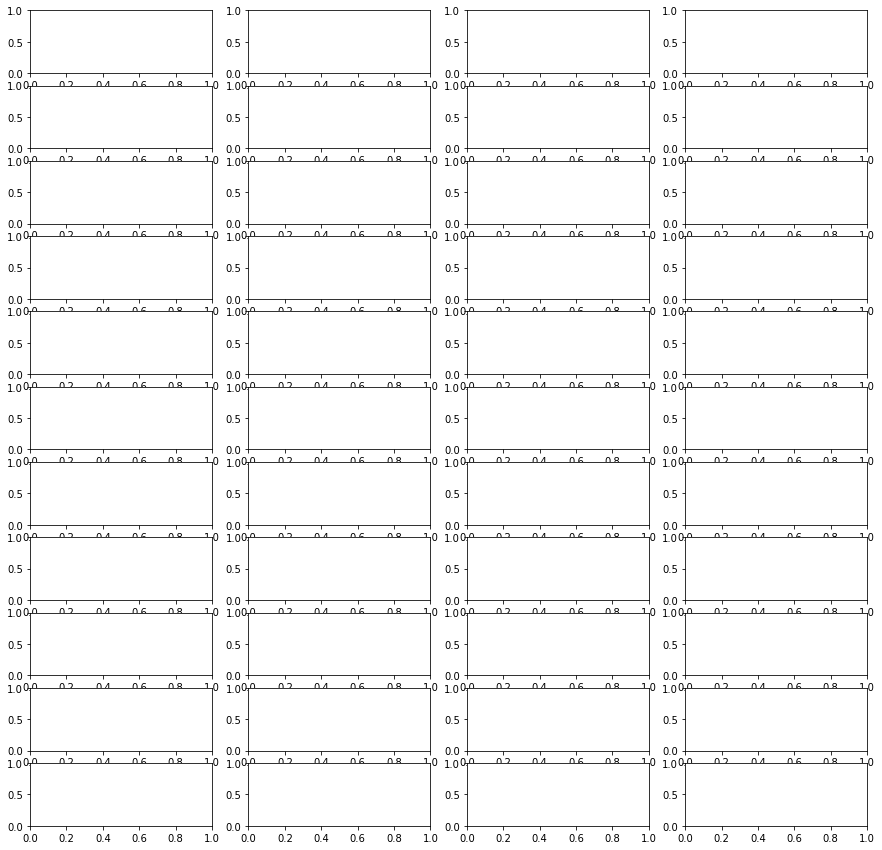

In [67]:
dp = 'Sud'
fig, axes = plt.subplots((len(compartments))//4+1, 4, figsize=(15,15), squeeze = True);
axes = axes.flatten();
for i, comp in enumerate(compartments):
    axes[i].fill_between(all_data_vacc[dp][comp]['q05'][ti:tf].index, all_data_vacc[dp][comp]['q05'][ti:tf], all_data_vacc[dp][comp]['q95'][ti:tf], alpha = .5, color = 'red', linewidth = 0)
    axes[i].plot(all_data_vacc[dp][comp]['mean'][ti:tf], linewidth=1, alpha = 1,linestyle='-.', color = 'black')
    axes[i].plot(all_data_vacc[dp][comp]['q50'][ti:tf], alpha = 1,linestyle='-', linewidth = 1, color = 'blue') 
    axes[i].set_title(comp)
    axes[i].legend()
    axes[i].set_ylim(0)
    
fig.tight_layout()

In [68]:
vacc_init = pd.DataFrame(np.nan, pd.DatetimeIndex(start =  datetime.date(2010,10,23), 
                                      end = t_for, freq = 'W-SAT'), columns = dept_name)

cases_df =  pd.DataFrame(np.nan, index = pd.DatetimeIndex(start =  t_start, 
                                      end = t_for, freq = 'W-SAT'), columns = dept_name)

for dp in dept_avail:
    cases_df[dp] = all_data_vacc[dp]['cases']['q50'][scenario.t_vacc_start[dp]+datetime.timedelta(days = 90) : scenario.t_vacc_start[dp] + datetime.timedelta(days = 200)]

for dp in dept_avail:
    vacc_init[dp] = covar_init[dp][datetime.date(2010,10,23):scenario.t_vacc_start[dp]]
    vacc_init[dp].fillna(cases_df[dp].mean(), inplace = True)
    
vacc_init.to_csv('vacc_init' + scenario_str +  '.csv', index_label='date')

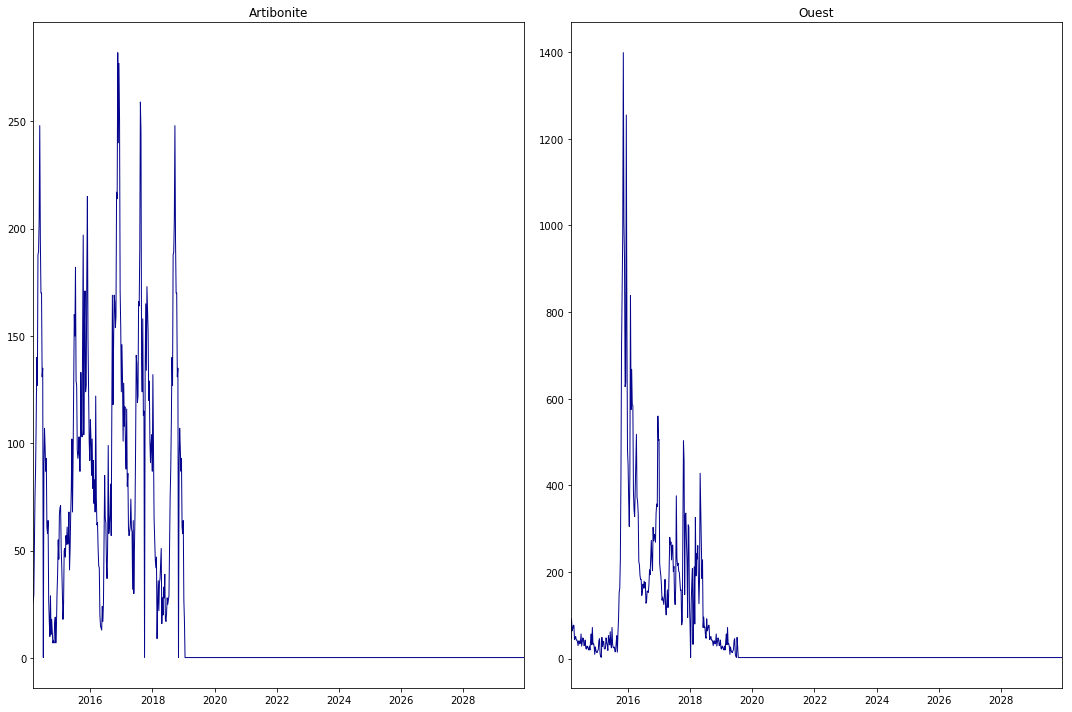

In [69]:
fig, axes = plt.subplots((len(all_data))//2, 2, figsize=(15,10), squeeze = True);
axes = axes.flatten();
fig.patch.set_facecolor('white')

for i, dp in enumerate(dept_avail):
    axes[i].plot(vacc_init[dp], alpha = 5,linestyle='-', linewidth = 1, color = 'darkblue')
    #axes[i].plot(covar_init[dp], alpha = 1,linestyle='-', linewidth = 1, color = 'red')
    axes[i].set_title(dp)
    #axes[i].set_ylim(0,10)
    axes[i].set_xlim(t_start, t_for)

fig.tight_layout()

### Projection with mobility

In [71]:
# Running simulation:
index = pd.DatetimeIndex(start =  t_start,  end = t_for, freq = 'W-SAT')
r_source = robjects.r['source'];

csv_all =  pd.DataFrame(0, index = pd.DatetimeIndex(start =  t_start, 
                        end = t_for, freq = 'W-SAT'), columns = dept_name)

vacc_init = pd.read_csv('vacc_init' + scenario_str +  '.csv', index_col = 0, parse_dates = True)
vacc_init.to_csv('covar_mob.csv', index_label='date')

all_data_vacc = {}
for i, dp in enumerate(dept_avail):
    dept_data = {}
    robjects.r('departement <- "' + dp + '"')
    robjects.r('output_dir <- "' + output_dir + '"')
    robjects.r('run_level <- ' + str(run_lvl))
    robjects.r('nsim <- ' + str(nsim))
    
    robjects.r('t_vacc_start <- "' + str(scenario.t_vacc_start[dp]) + '"')
    robjects.r('t_vacc_end  <- "' + str(scenario.t_vacc_end[dp]) + '"')
    robjects.r('p1d_reg <- ' + str(scenario.p1d_reg[dp]))
    robjects.r('r_v_year <- ' + str(scenario.r_v_year[dp]))
    robjects.r('cases_ext <- 1')

    print(dp)

    r_source('~/phd/haiti-ocv-pomp/scripts/forecast_haitiOCV_mob.R')
  
    for comp in compartments:
        temp = pandas2ri.ri2py(robjects.r[comp])
        temp.index = index
        temp.drop('date',axis=1, inplace = True)
        dept_data[comp] = temp
    all_data_vacc[dp] = dept_data
    csv_all[dp] = all_data_vacc[dp]['cases']['q50']

Artibonite


RRuntimeError: Error in Summary.factor(c(NA, NA, NA, NA, NA, NA, 135L, NA, NA), na.action = NULL,  : 
  'sum' not meaningful for factors


In [ ]:
ti = input_parameters['t_start']
ti = input_parameters['t_end']
tf = t_for

fig, axes = plt.subplots((len(all_data))//2, 2, figsize=(15,15), squeeze = True, dpi = 200);
axes = axes.flatten();
fig.patch.set_facecolor('white')

for i, dp in enumerate(dept_avail):
    axt =  axes[i].twinx()
    axes[i].plot(cases[dp][ti:tf][t_start:], marker='.', linestyle='-',color='k', linewidth=0, markersize=1 ) 
    axes[i].fill_between(all_data_vacc[dp]['cases']['q05'][ti:tf].index, all_data_vacc[dp]['cases']['q05'][ti:tf], all_data_vacc[dp]['cases']['q95'][ti:tf], alpha = .5, color = 'red', linewidth = 0)
    axes[i].plot(all_data_vacc[dp]['cases']['q50'][ti:tf], alpha = 1,linestyle='-', linewidth = 1, color = 'darkblue')
    axt.bar(pd.date_range(t_start,t_for, freq='W-SAT').date, rain[dp].resample('W-SAT').sum()[t_start:t_for], 
                label = r'Rainfall', color = 'darkblue', width=7, alpha = 1)

    axes[i].set_title(dp)
    axes[i].set_ylim(0)
    axt.set_ylim(2*max(rain[dp].resample('W-SAT').sum()[t_start:t_for]),0) # check if only reverse y
    axes[i].set_xlim(ti, tf)
    #axes[i].legend()
    
    # convert to matplotlib date representation
    start = mdates.date2num(scenario.t_vacc_start[dp])
    end = mdates.date2num(scenario.t_vacc_end[dp])
    width = end - start
    rect = Rectangle((start, 0), width, 100+max(all_data_vacc[dp]['cases']['q95']), color='orange', alpha= 0.1)
    axes[i].add_patch(rect) 
    axes[i].add_artist(rect)
    rx, ry = rect.get_xy()
    cx = rx + rect.get_width()/2.0
    cy = ry + rect.get_height()/1.5
    #axes[i].annotate(r'Vaccination', (cx, cy), color='black',# weight='bold', 
    #            fontsize=12, ha='center', va='center', rotation='vertical')

fig.tight_layout()

### Playground

In [379]:
csv_all_q50 =  pd.DataFrame(0, index = pd.DatetimeIndex(start =  t_start, 
                                      end = t_for, freq = 'W-SAT'), columns = dept_name)

csv_all_q05 =  pd.DataFrame(0, index = pd.DatetimeIndex(start =  t_start, 
                                      end = t_for, freq = 'W-SAT'), columns = dept_name)

csv_all_q95 =  pd.DataFrame(0, index = pd.DatetimeIndex(start =  t_start, 
                                      end = t_for, freq = 'W-SAT'), columns = dept_name)

In [380]:
for dp in dept_avail:
        csv_all_q50[dp] = all_data[dp]['cases']['q50']
        csv_all_q95[dp] = all_data[dp]['cases']['q95']
        csv_all_q05[dp] = all_data[dp]['cases']['q05']
        
csv_all_q05.to_csv('S0_q05.csv', index_label='date')
csv_all_q95.to_csv('S0_q95.csv', index_label='date')
csv_all_q50.to_csv('S0_q50.csv', index_label='date')
pd.concat([csv_all_q05.sum(axis=1), csv_all_q50.sum(axis=1), csv_all_q95.sum(axis=1)], axis = 1, keys = ['q05', 'q50', 'q95']).to_csv('S0_national.csv', index_label='date')

In [291]:
for dp in dept_avail:
        csv_all_q50[dp] = all_data_vacc[dp]['cases']['q50']
        csv_all_q95[dp] = all_data_vacc[dp]['cases']['q95']
        csv_all_q05[dp] = all_data_vacc[dp]['cases']['q05']
        
csv_all_q05.to_csv(scenario_str + '_q05.csv', index_label='date')
csv_all_q95.to_csv(scenario_str + '_q95.csv', index_label='date')
csv_all_q50.to_csv(scenario_str + '_q50.csv', index_label='date')
pd.concat([csv_all_q05.sum(axis=1), csv_all_q50.sum(axis=1), csv_all_q95.sum(axis=1)], axis = 1, keys = ['q05', 'q50', 'q95']).to_csv(scenario_str + '_national.csv', index_label='date')

for dp in dept_avail:
        csv_all_q50[dp] = all_data_vacc[dp]['C']['q50']
        csv_all_q95[dp] = all_data_vacc[dp]['C']['q95']
        csv_all_q05[dp] = all_data_vacc[dp]['C']['q05']
        
csv_all_q05.to_csv(scenario_str + '_q05_s.csv', index_label='date')
csv_all_q95.to_csv(scenario_str + '_q95_s.csv', index_label='date')
csv_all_q50.to_csv(scenario_str + '_q50_s.csv', index_label='date')
pd.concat([csv_all_q05.sum(axis=1), csv_all_q50.sum(axis=1), csv_all_q95.sum(axis=1)], axis = 1, keys = ['q05', 'q50', 'q95']).to_csv(scenario_str + '_national_s.csv', index_label='date')

### Elimination probability

In [366]:
sc = 'S6'
sims = pd.read_csv('all_sim' + sc +  '.csv', index_col = 0, parse_dates = True)
t_init = datetime.date(2018,7,14)
#1100 cases per year
#1.1 cases

pc_them = 0
pc_us = 0
for i in range(10):
    smlr = sims[str(i)][t_init:datetime.date(2022,12,31)].rolling(52).sum()
    if smlr.min() < 1100:
        pc_them += 10
    if smlr.min() < 1.1:
        pc_us += 10

        
# S1: 100 and 0
# S2: 0 and 0
# S3: 0 0
# S4 100 and 0
# S5 0 and 0
# S6 0 and 0
print(pc_them, pc_us)

0 0


In [391]:
t_init

datetime.date(2018, 7, 14)

In [406]:
cases= pd.read_csv('output_4group/S6/S6_national.csv', index_col = 0, parse_dates = True)


In [407]:
cases['q50'][t_init:datetime.date(2021,12,31)].sum()

19826.5

In [410]:
difference={'S0':129976.5,
'S1':11741.5,
'S2':39428.0,
'S3':22601.5,
'S4':8440.5,
'S5':29400.0,
'S6':19826.5}

### Quantile national

In [412]:
for key in difference:
    print(key, difference[key]/difference['S0'])

S0 1.0
S1 0.0903355606590422
S2 0.30334714352209824
S3 0.17388912611125856
S4 0.064938661988898
S5 0.22619473520213268
S6 0.1525391128396287


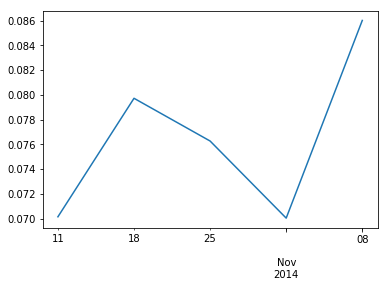

In [8]:
all_data[dp]['B']['q50'][datetime.date(2014,10,10):datetime.date(2014,11,10)].plot()

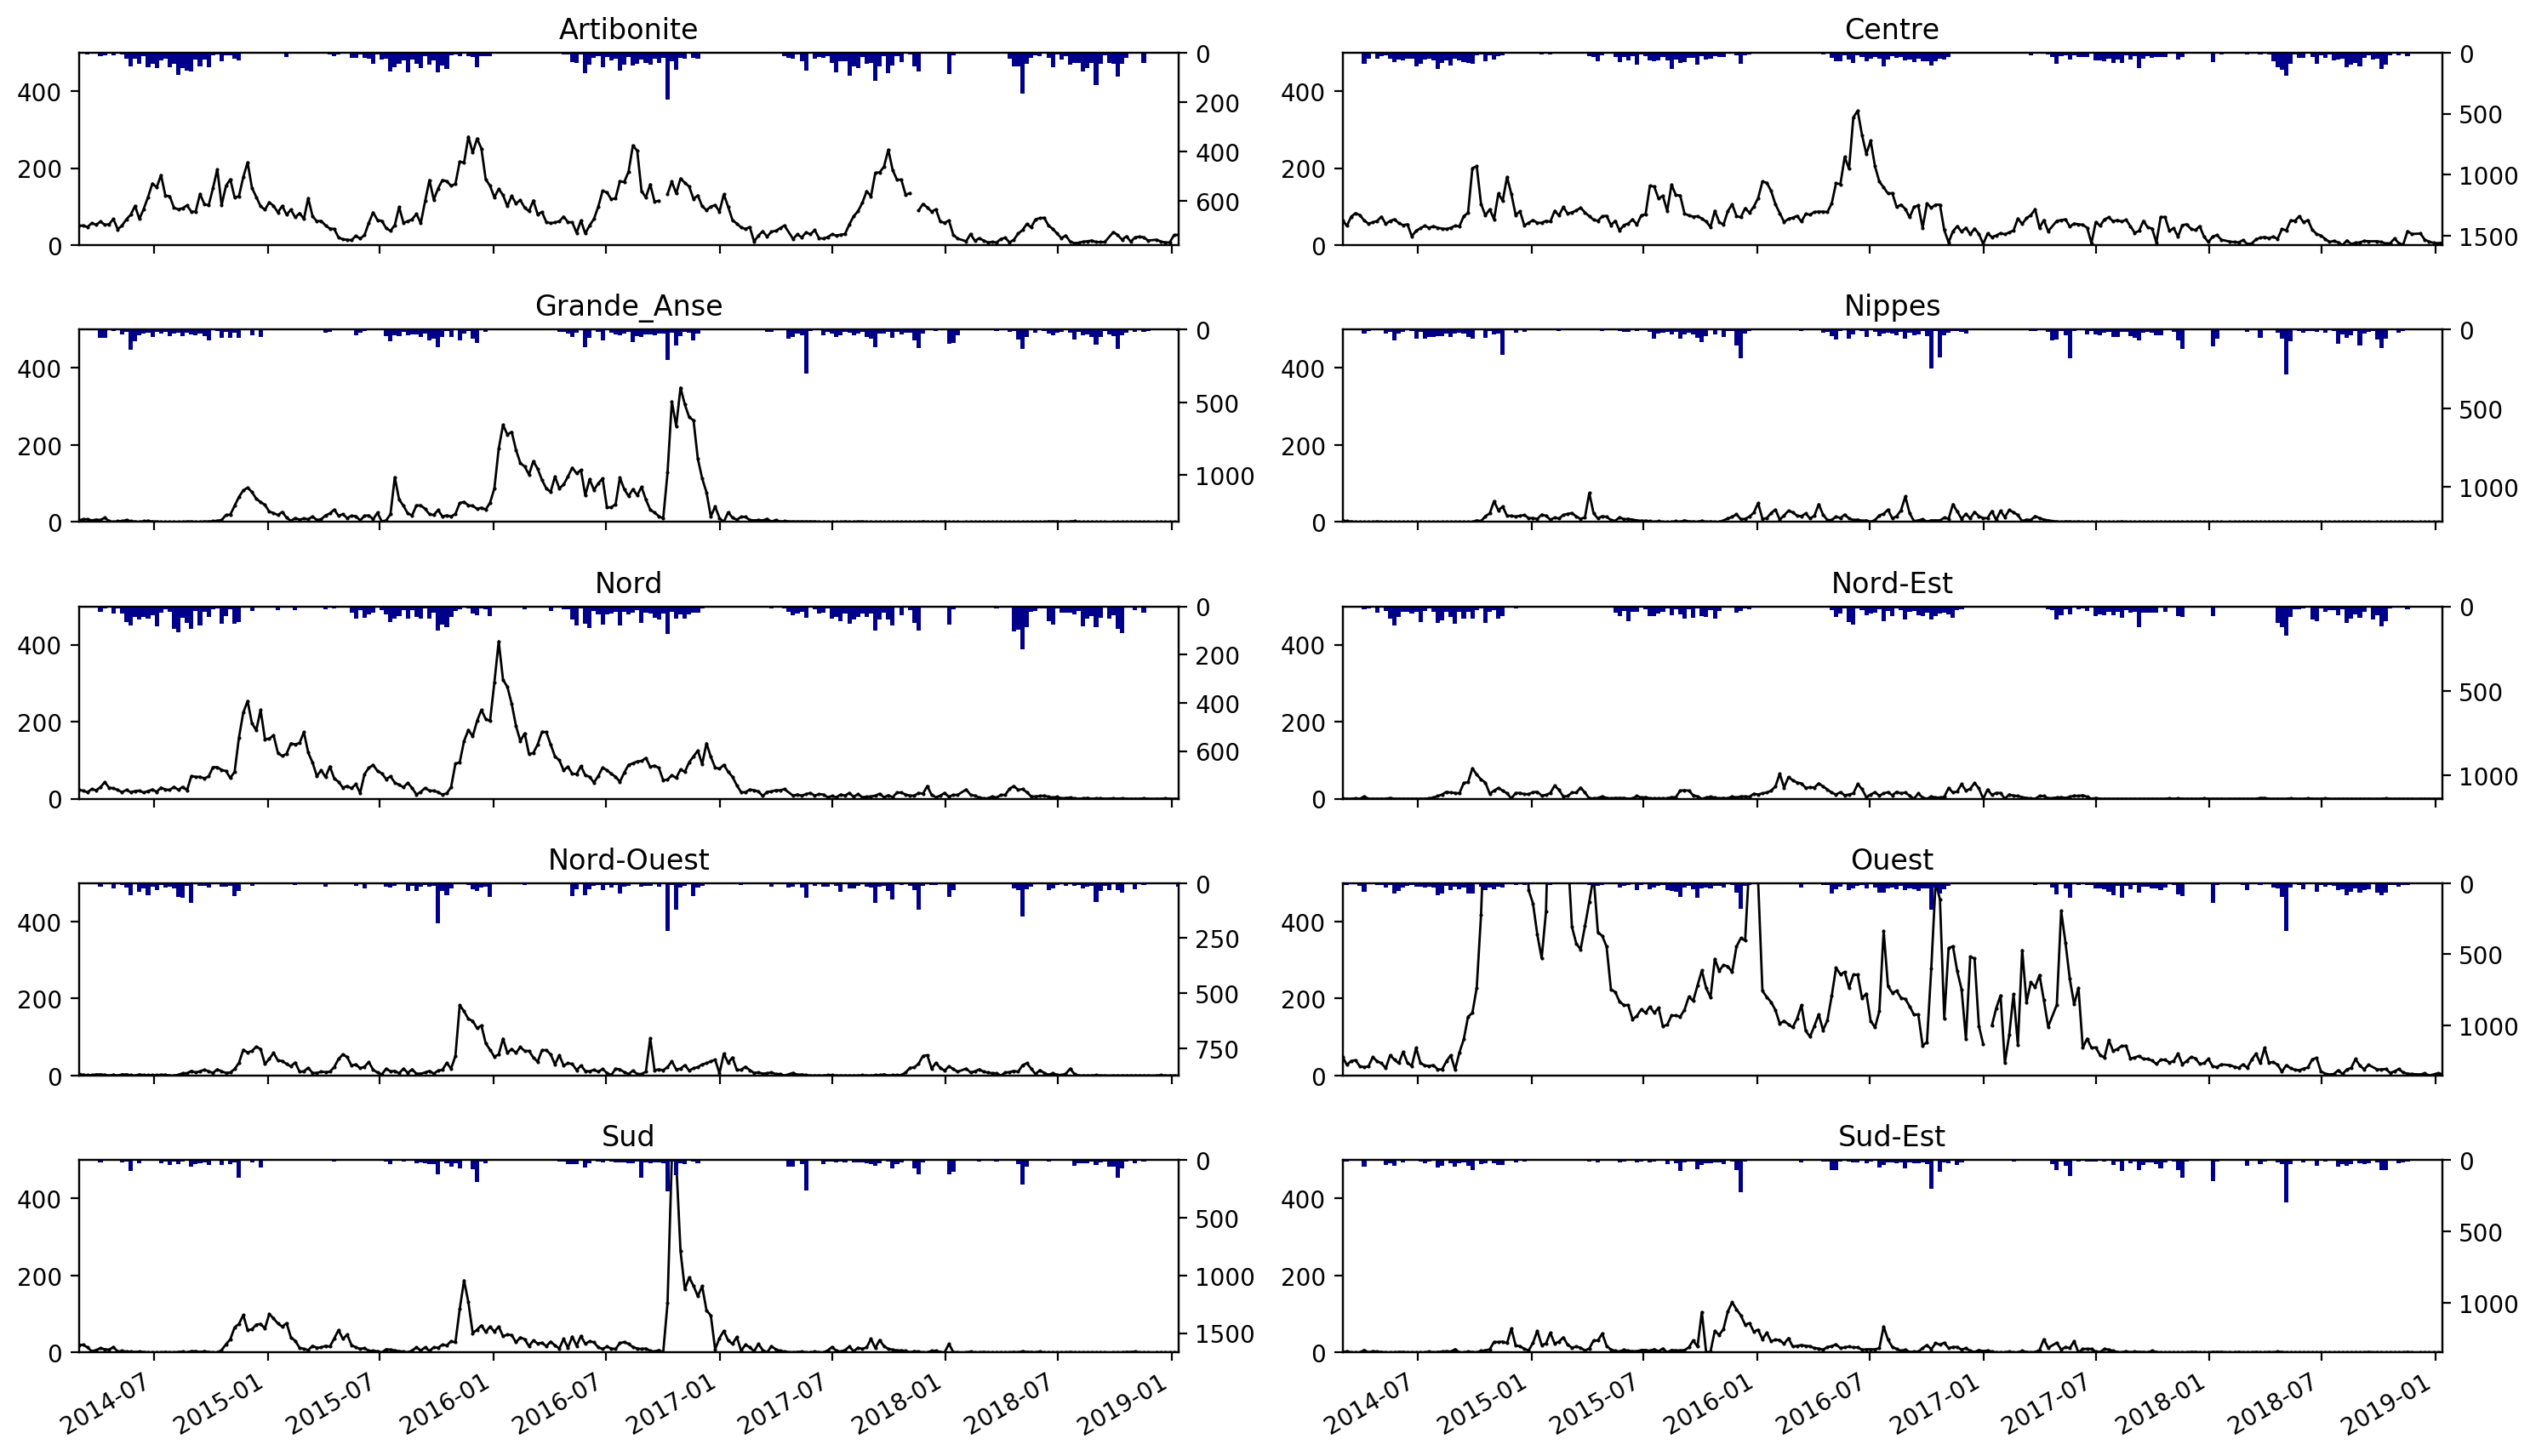

In [7]:
ti = input_parameters['t_start']
tf = input_parameters['t_end']

fig, axes = plt.subplots(5, 2, figsize=(15,10), squeeze = True, dpi = 200);
fig.patch.set_facecolor('white')
axes = axes.flatten();
for i, dp in enumerate(cases.columns):

    axt =  axes[i].twinx()
    axes[i].plot(cases[dp][t_start:][ti:tf], marker='.', linestyle='-',color='k', linewidth=1, markersize=1 ) 
    axt.bar(pd.date_range(ti,tf, freq='W-SAT').date, rain[dp].resample('W-SAT').sum()[ti:tf], 
    label = r'Rainfall', color = 'darkblue', width=7, alpha = 1)

    axes[i].set_title(dp)
    axes[i].set_ylim(0, 500)
    axt.set_ylim(4*max(rain[dp].resample('W-SAT').sum()[t_start:t_for]),0) # check if only reverse y
    axes[i].set_xlim(ti, tf)
    #axes[i].legend()
    
fig.tight_layout()
fig.autofmt_xdate()

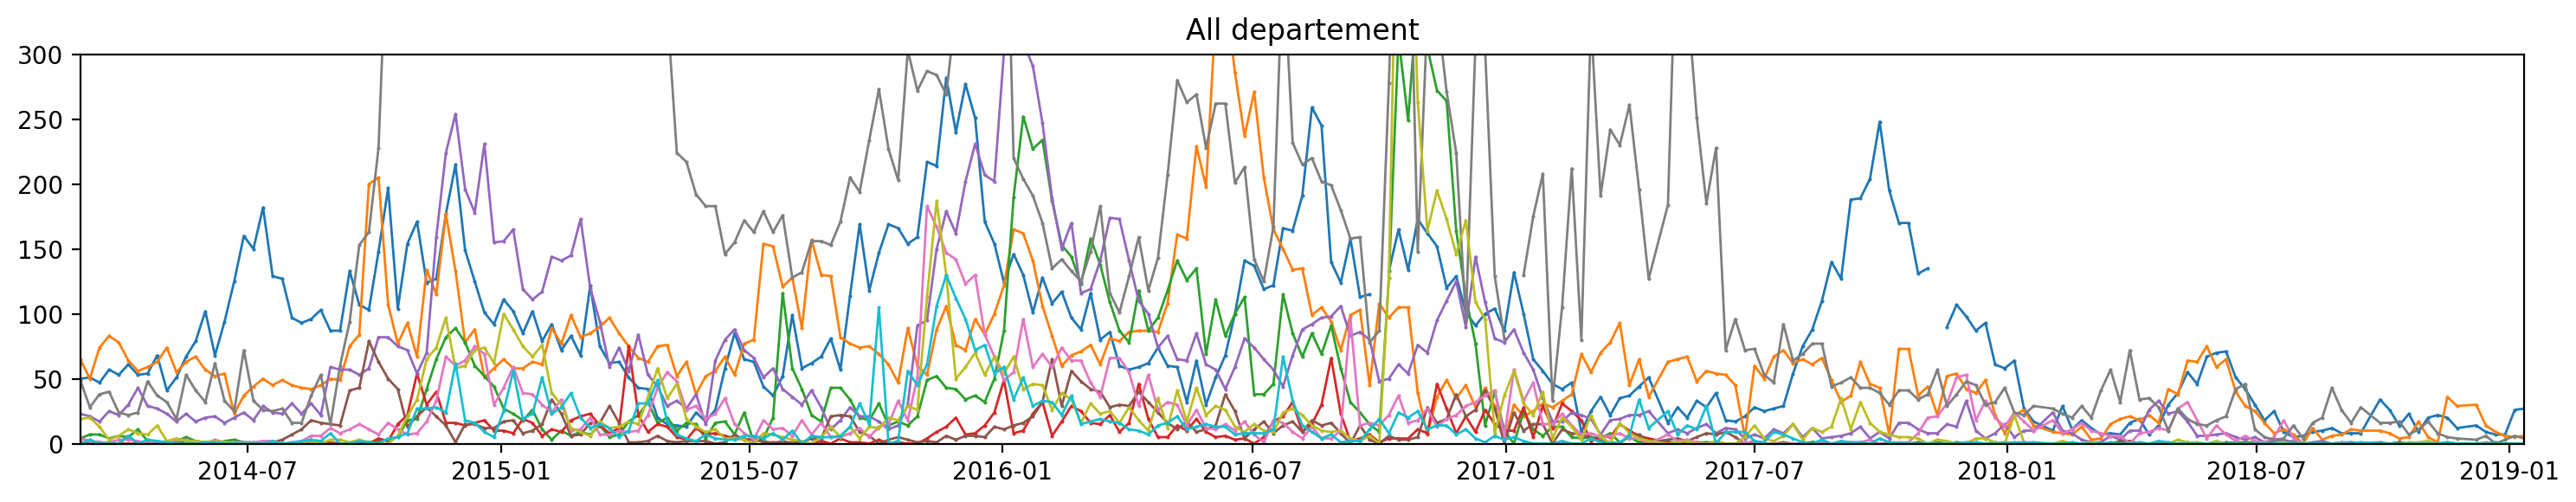

In [3]:
ti = input_parameters['t_start']
tf = input_parameters['t_end']

fig, axes = plt.subplots(1, 1, figsize=(15,3), squeeze = True, dpi = 200);
fig.patch.set_facecolor('white')
for i, dp in enumerate(cases.columns):

    axes.plot(cases[dp][t_start:][ti:tf], marker='.', linestyle='-', linewidth=1, markersize=1, label=dp ) 

    axes.set_title('All departement')
    axes.set_xlim(ti, tf)
    axes.set_ylim(0, 300)
    
    
fig.tight_layout()

In [102]:
cases.columns

Index(['Artibonite', 'Centre', 'Grande_Anse', 'Nippes', 'Nord', 'Nord-Est',
       'Nord-Ouest', 'Ouest', 'Sud', 'Sud-Est'],
      dtype='object')